In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# best way to learn about the statistics of something is by counting
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
        

In [5]:
sorted(b.items(), key=lambda kv: -kv[1])[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

In [6]:
import torch

In [7]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [8]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [9]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

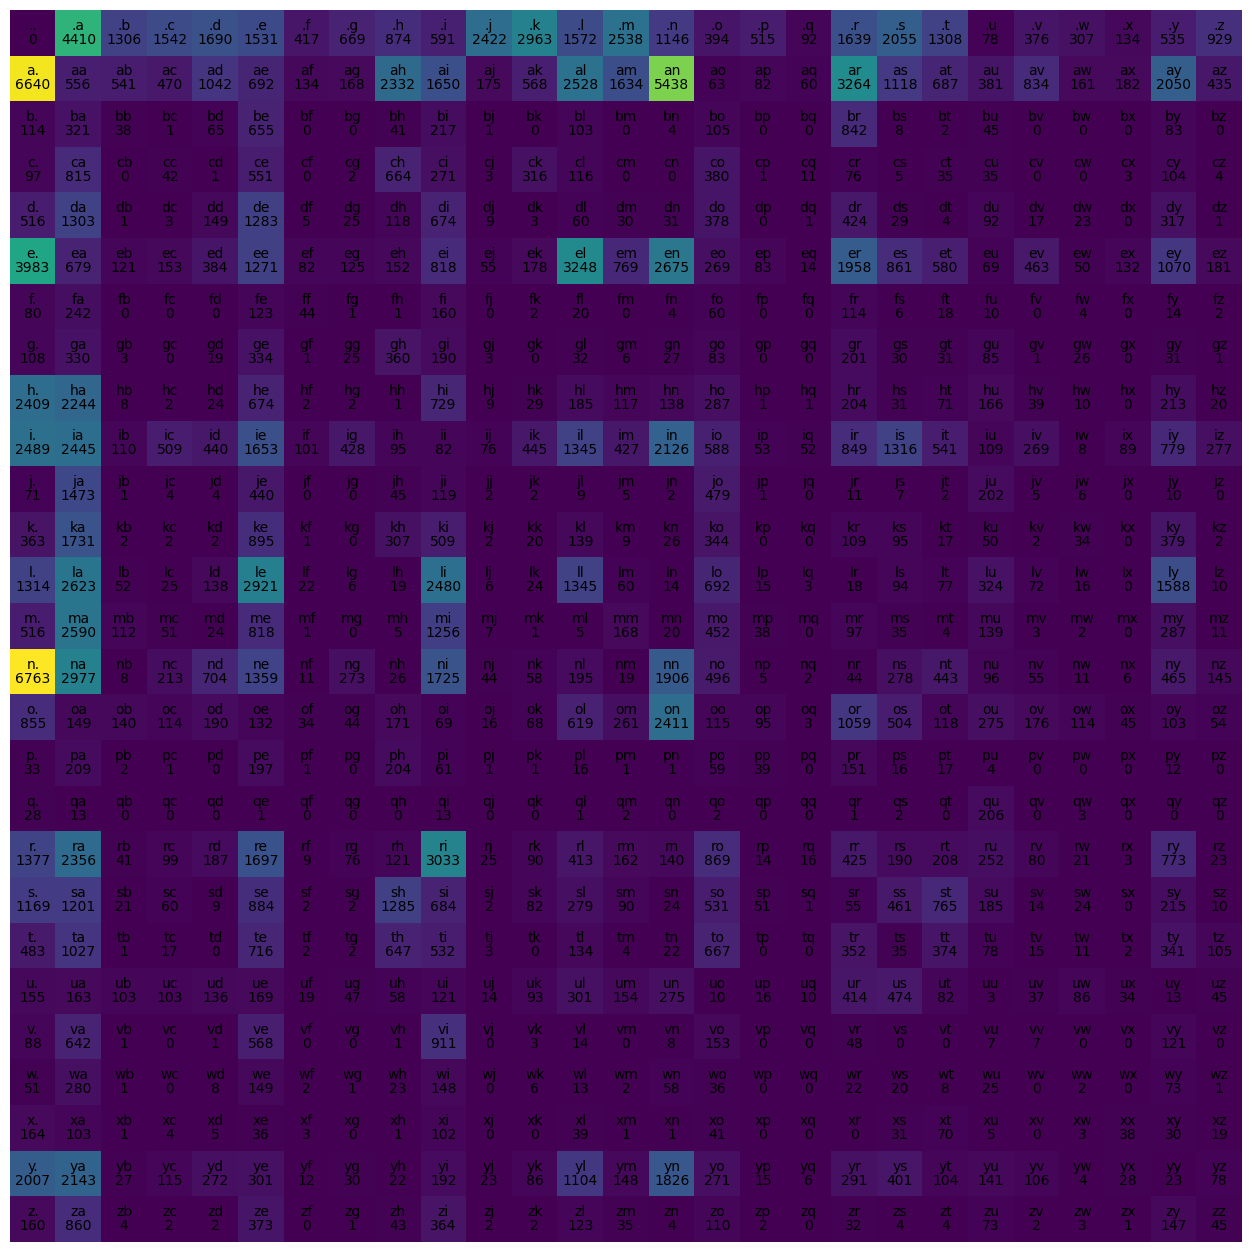

In [11]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom")
        plt.text(j, i, N[i, j].item(), ha="center", va="top")
plt.axis('off');

plt.imshow(N)

In [12]:
N[0, :]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [13]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [14]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [15]:
# 27, 27
# 27, 1
# The sum below will sum across the first dimension, which is the rows. We end up with a column vector.
# It will then broadcast (extend) the the sum of row i across each element of row i.
# If we do not use keepdim=True, it will squeeze out the dim 1, and since we align on the right in broadcasting, we would end up with
# 27, 27
#     27
# As we see, we have a vector of second dimension, which is a row vector. It will then vertically fill in this row, and populate each row with a copy of 
# our row vector.

# N+1 instead of N for probability smoothing, otherwise if we encounter a name that has not been in the trainingset, it will get likelihood 0 (and thus lim -log(0) = infinity)
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [16]:
g = torch.Generator().manual_seed(2147483647)

out = []
ix = 0
for i in range(10):
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break;

print(''.join(out))

junide.janasah.p.cony.a.nn.kohin.tolian.juee.ksahnaauranilevias.


**Goal**: maximize liklihood (product of probabilities) of the data w.r.t. model parameters (statistical modeling)

equivalent to maximizing the log likelihood (bc log is monotonic)
equivalent to minimizing the negative log likelihood
equivalent to minimizing the average negative log likelihood

`log(a*b*c) = log(a) + log(b) + log(c)`

In [17]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob =torch.log(prob)
        log_likelihood += logprob
        n+=1
        #print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


## Neural Network approach

Create a training set of the bigrams

In [18]:
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] +  list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [19]:
xs

tensor([ 0,  5, 13, 13,  1])

In [20]:
ys

tensor([ 5, 13, 13,  1,  0])

In [21]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float() # input to the networks: one-hot encoding

In [22]:
xenc.shape

torch.Size([5, 27])

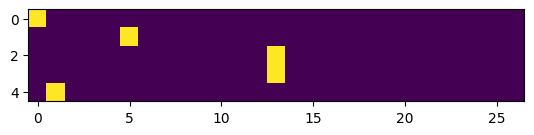

In [23]:
plt.imshow(xenc)

In [24]:
xenc.dtype

torch.float32

In [25]:
# randomly init 27 neurons' weights. each neuron receives 27 inputs. Thus each neuron is a row vector of size 27 organized in a matrix (stacked on top of each other).

W = torch.randn((27, 27)) # 27 * 27. We have 27 weight vectors (Ws) and each weight vector has a dedicated weight for the input on the previous layer


In [26]:
logits = (xenc @ W) # log-counts
counts = logits.exp() # log counts (similar to counts in table above ==> N)
probs = counts / counts.sum(1, keepdims=True)
#  btw: the last 2 lines here are together called a 'softmax'
probs.shape

torch.Size([5, 27])

In [27]:
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0] 

(tensor(0.0197),
 tensor(0.0040),
 tensor(0.0129),
 tensor(0.0283),
 tensor(0.0199))

In [28]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [29]:
probs[torch.arange(5), ys]

tensor([0.0197, 0.0040, 0.0129, 0.0283, 0.0199])

In [30]:
# Optimization, lets summarize! 

In [31]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] +  list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of exampels: ", num)

# init the 'network'
# random init of 27 neurons' wieghts, each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # required grad gotta be passed, as otherwise we wont have the gradient

number of exampels:  228146


In [32]:
# gradient descend
for k in range(50):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the netowrk: one-hot encoding
    logits = xenc @ W #predict log counts
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())

    # backward pass
    W.grad = None # set the gradient to zero
    loss.backward()

    # update 
    W.data += -50 * W.grad # update tensor (update weights)

3.758953809738159
3.371098756790161
3.1540417671203613
3.020373821258545
2.9277119636535645
2.860402822494507
2.8097293376922607
2.7701027393341064
2.7380733489990234
2.711496591567993
2.6890034675598145
2.6696884632110596
2.6529300212860107
2.638277292251587
2.6253881454467773
2.6139907836914062
2.603863477706909
2.5948219299316406
2.586712121963501
2.57940411567688
2.572789192199707
2.5667762756347656
2.5612881183624268
2.5562589168548584
2.551633596420288
2.547365665435791
2.5434155464172363
2.539748430252075
2.5363364219665527
2.5331544876098633
2.5301806926727295
2.5273969173431396
2.5247862339019775
2.522334575653076
2.520029067993164
2.517857789993286
2.515810966491699
2.513878345489502
2.512052059173584
2.510324001312256
2.5086867809295654
2.5071346759796143
2.5056610107421875
2.5042612552642822
2.502929210662842
2.5016613006591797
2.5004522800445557
2.4992990493774414
2.498197317123413
2.497144937515259
